# What Was the Effect of The Boston Marathon on Airbnb Listing Prices in 2017?
### By: Eli Easton


# 1. Introduction

# 2. Data Cleaning & Loading

I first begin with the Boston Airbnb Calendar dataset. This dataset was sourced from Kaggle and contains 1.05 million observations, where the unit of observation is an Airbnb listing-date in Boston Massachusetts from September 2016 to September 2017. Evidently, this dataset follows a panel structure. The variables in this dataset are a listing id, the date of listing, a dummy for if the listing is available on that date, and a price variable. This dataset is crucial for my analysis because it contains every listing date for a single Airbnb property over the stated time period and the associated price for each listing, thus allowing me to observe the change in a property's listing price over time.

To obtain more information on each Airbnb property, I then merge the Boston Airbnb Listings dataset, which was also sourced from Kaggle, to the Calendar dataset. The Listings dataset is of a cross-sectional structure and contains 3586 observations where each unit of observation is a listing, or in other words a Airbnb property that was active between September 2016 and September 2017. . This dataset contains 95 variables including listing id, listing property type, listing room type, listing amenities, neighborhood amenities, location variables, information on the host, booking rules and information variables, and listing review variables. The Listings dataset ultimately provides me detailed information on each Airbnb property, which, when merged with the Calendar dataset, can be used as controls when estimating the causal effect of the 2017 Boston Marathon on listing prices.   

It is understood that the level of crime in a neighbourhood impacts property value (). Therefore, I also merge in the Crimes in Boston dataset, which was sourced from Kaggle. The Crimes dataset follows a cross-sectional structure and contains 327 821 observations, where the unit of observation is an incident, and has 17 variables including type of crime variables, date variables, and location variables. The information from the Crimes dataset will then be used to control for crime at a neighbourhood level to better estimate the causal effect of the Boston Marathon on listing prices.

The period of interest for my analysis is September 2016 to September 2017. My population of interest are Airbnb’s in Boston Massachusetts, and my main outcome variable of interest is Airbnb listing prices. As properties are not randomly treated with "Boston Marathon" or "No Boston Marathon," my research design is as follows. Neighbourhoods near the Boston Marathon will be in my treatment group, while neighbourhoods farther away from the Boston marathon will be in my control group. For instance, the marathon passes through Back Bay, while West Roxbury is far from the marathon and is assumed to be less affected by increased Airbnb demand, making the former a treated neighbourhood and the latter a control. However, these neighbourhoods are not ‘apples to apples,’ and likely differ systematically. Thus, I will introduce control variables to make like comparisons. Currently, my main controls of interest are room type, property type, bed type, number of bathrooms, number of bedrooms, number of beds, review score rating, and a dummy for if the host is a "superhost." In future projects, I will introduce property amenity controls and locational controls, such as neighborhood fixed, which account for neighborhood amenities and neighborhood-level crime data.

The rationale for my current selection of controls is as follows. First, room type has a wide and diverse range of categorical values ranging from “entire home” to “shared room,” making it reasonable to assume that these categories influence listing price. Similarly, property type varies from a whole house to a dorm, while bed type ranges from a real bed to a couch, making them also likely determinants of price. This same logic also applies to the number of bathrooms (0 to 6), the number of bedrooms (0 to 5), and the number of beds (0 to 16). Akin to _, review score rating can serve as a proxy for a property’s quality, which influences price. Lastly, a host’s 'superhost' status is another indicator of quality that may impact pricing.



In [76]:
#! pip install -q matplotlib numpy pandas qeds seaborn

In [77]:
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds
import seaborn as sns

#Change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

#Load calendar dataset
calendar = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\Boston\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)
#Clean "price column"
calendar["price"] = calendar["price"].astype(str).str.replace("$", "").str.replace(".00", 
                                                                                   "").str.replace(",", "").astype(float)
#Create "year_month" column from the "date" column in "df_calendar" dataset
calendar["date"] = pd.to_datetime(calendar["date"])
calendar["year_month"] = calendar["date"].dt.to_period("M")

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\Boston\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_id", 
                       "host_url", "host_name", "host_since", "host_location", "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", "host_listings_count", "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "neighbourhood", "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", "first_review", "last_review", 
                       "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", 
                       "review_scores_communication", "review_scores_location", "review_scores_value", "requires_license", 
                       "license", "jurisdiction_names", "instant_bookable", "cancellation_policy", 
                       "require_guest_profile_picture", "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", "security_deposit", "price", 
                       "number_of_reviews"], inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})
#Room type
for room in ["Entire home/apt", "Private room", "Shared room"]:
    listings[room] = listings["room_type"].map({room: 1}).fillna(0).astype(int)
#Property type
for property in ["Apartment", "House", "Condominium", "Townhouse", "Guesthouse", "Loft", "Villa", "Dorm", "Entire Floor", 
                 "Bed & Breakfast", "Boat", "Camper/RV", "Other"]:
    listings[property] = listings["property_type"].map({property: 1}).fillna(0).astype(int)
#Bed type
for bed in ["Real Bed", "Futon", "Pull-out Sofa", "Couch", "Airbed"]:
    listings[bed] = listings["bed_type"].map({bed: 1}).fillna(0).astype(int)
#Neighbourhood
for neighbourhood in ["Allston", "Back Bay", "Bay Village", "Beacon Hill", "Brighton", "Charlestown", "Chinatown", "Dorchester",
                      "Downtown", "East Boston", "Fenway", "Hyde Park", "Jamaica Plain", "Longwood Medical Area", 
                      "Leather District", "Mattapan", "Mission Hill", "North End", "Roslindale", "Roxbury", 
                      "South Boston", "South Boston Waterfront", "South End", "West End", "West Roxbury"]:
    listings[neighbourhood] = listings["neighbourhood_cleansed"].map({neighbourhood: 1}).fillna(0).astype(int)

#Merge datasets
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

#Load crime dataset
crime = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\crime.csv", encoding="latin1", 
                    low_memory=False)

#Clean "crime"
crime.drop(columns=["INCIDENT_NUMBER", "OFFENSE_CODE", "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", "SHOOTING", 
                    "DAY_OF_WEEK", "HOUR", "UCR_PART", "Lat", "Long", "STREET"], inplace=True)
crime["OCCURRED_ON_DATE"] = pd.to_datetime(crime["OCCURRED_ON_DATE"])
crime["year_month_crime"] = crime["OCCURRED_ON_DATE"].dt.to_period("M")
crime = crime[(crime["year_month_crime"] >= "2016-09") & (crime["year_month_crime"] <= "2017-09")]

#Stack "cal_lis" and "crime" datasets
CalLisCrime = pd.concat([cal_lis, crime], axis = 0)

CalLisCrime

,id,date,available,price,year_month,host_is_superhost,host_total_listings_count,street,neighbourhood_cleansed,city,...,South Boston Waterfront,South End,West End,West Roxbury,OFFENSE_CODE_GROUP,OCCURRED_ON_DATE,YEAR,MONTH,Location,year_month_crime
0,3353.0,2017-09-05,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
1,3353.0,2017-09-04,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
2,3353.0,2017-09-03,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
3,3353.0,2017-09-02,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
4,3353.0,2017-09-01,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327772,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Auto Theft Recovery,2016-09-23 19:15:00,2016.0,9.0,"(42.34695268, -71.05112684)",2016-09
327776,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Warrant Arrests,2016-09-12 09:00:00,2016.0,9.0,"(42.36240281, -71.06954652)",2016-09
327777,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Warrant Arrests,2017-01-20 02:00:00,2017.0,1.0,"(42.33001318, -71.09117863)",2017-01
327778,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Drug Violation,2017-01-20 02:00:00,2017.0,1.0,"(42.33001318, -71.09117863)",2017-01


# 3. Summary Statistics Tables

## 3.1. Summary Statistics of Outcome and Key Control Variables

In [78]:
#Generate Summary Statistics of price, bathrooms, bedrooms, beds, and review scores
listings_temp1 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats1 = listings_temp1[["price", "bathrooms", "bedrooms", "beds", "review_scores_rating", 
                          "Superhost"]].describe().round(3)

#Rename rows
summary_stats1.index = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
    "Median (50th Percentile)", "75th Percentile", "Maximum"]

#Rename columns
summary_stats1.rename(columns={"price": "Price", "bathrooms": "Bathrooms", "bedrooms": "Bedrooms",
                               "beds": "Beds", "review_scores_rating": "Review Scores Rating"}, inplace=True)

#Create title
summary_stats1.style.set_caption("Table 1: Summary Statistics of Price and \
                                                         Key Variables for Airbnb Listings - Boston, MA").format("{:.3f}")


,Price,Bathrooms,Bedrooms,Beds,Review Scores Rating,Superhost
Total Observations,1788.000,3571.000,3575.000,3576.000,2772.000,3585.000
Mean,195.423,1.222,1.256,1.609,91.917,0.114
Standard Deviation,187.577,0.501,0.753,1.012,9.532,0.317
Minimum,20.000,0.000,0.000,0.000,20.000,0.000
25th Percentile,81.000,1.000,1.000,1.000,89.000,0.000
Median (50th Percentile),150.000,1.000,1.000,1.000,94.000,0.000
75th Percentile,250.000,1.000,2.000,2.000,98.250,0.000
Maximum,4000.000,6.000,5.000,16.000,100.000,1.000


Table 1 provides an overview of key characteristics, which will be used as controls, of Airbnb properties in Boston, MA that were active between September 2016 and September 2017. 

The average number of bathrooms, bedrooms, and beds being 1.2, 1.3, and 1.6 respectively indicate that most properties are small. However, these variables have large outliers and the median for all three of these variables is 1, indicating a mean which is biased upwards and a right skew in the distribution. These extreme observations will need to be controled for my analysis. 

Furthermore, Airbnb review scores are consistently high, with an average of 91.9 out of 100, and a median of 94, ultimately suggesting a left skew in the distribution. This may indicate an unobserved bias among guests. Maybe those who had a bad experience are less likely to leave a review or vice versa. These findings bring into question whether review scores are a meaningful proxy for quality. 

It also appears that superhosts are fairly rare, with only 11.4% of hosts meeting the criteria. Given that superhosts likely differ systematically from non-superhosts, this selection bias will have to be accounted for in my analysis.

Importantly, the summary statistics for the price variable in Table 1 likely does not capture the true variation in listing prices. This is because Table 1 presents only a single observed price for each listing rather than the range of prices that a listing experiences over time. Accordingly, price summary statistics should be presented as is below.

In [79]:
summary_stats2 = CalLisCrime.groupby("year_month")["price"].describe().round(2)

summary_stats2.rename(columns={"count": "Count", "mean": "Mean", "std": "Standard Deviation",
                               "min": "Minimum", "25%": "25th Percentile", 
    "50%": "Median (50th Percentile)", "75%": "75th Percentile", "max": "Maximum"}, inplace=True)

summary_stats2.rename_axis(index="Year-Month", inplace=True)

summary_stats2.style.set_caption("Table 2: Summary Statistics of Price over Time - Boston, MA: September 2016 - September 2017").format("{:.2f}")

,Count,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Year-Month,,,,,,,,
2016-09,24401.00,252.68,193.50,22.00,100.00,209.00,375.00,4000.00
2016-10,46345.00,233.42,185.67,20.00,95.00,185.00,329.00,7163.00
2016-11,58888.00,202.92,167.08,20.00,90.00,160.00,270.00,4000.00
2016-12,60997.00,192.60,162.01,20.00,90.00,155.00,250.00,4000.00
2017-01,63181.00,182.80,155.36,20.00,85.00,150.00,240.00,4000.00
2017-02,56810.00,180.96,160.77,20.00,85.00,150.00,239.00,4000.00
2017-03,55181.00,181.82,168.96,20.00,85.00,149.00,239.00,4000.00
2017-04,51382.00,197.25,191.83,20.00,83.00,150.00,250.00,4000.00
2017-05,53600.00,193.71,184.61,11.00,80.00,150.00,250.00,4000.00


Table 2 provides monthly summary statistics for Airbnb listing prices in Boston, MA from September 2016 to September 2017.

This table shows that average listing price over the time period undergoes seasonal fluctuations, with average prices decreasing in the winter months, September to February, and then increasing in the summer months. This seasonality will need to be accounted for in my analysis. The data also have high maximum values, suggesting a right skew and outlier observations that need to be handled before a regression is run. The standard deviations are also quite high, indicating substantial variation in prices. Importantly, there is a large jump in average prices (comapred to the other increases) in April 2017, which was the month of the Boston Marathon, thus supporting my hypothesis that the Boston Marathon has an effect on Airbnb listing prices.

## 3.2. Summary Statistics of Airbnb Listings by Room Type

In [80]:
#Generate summary stats of room type
listings_temp2 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats3 = listings_temp2[["Entire home/apt", "Private room", "Shared room"]].describe().round(3)

#Rename columns
summary_stats3.index = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
    "Median (50th Percentile)", "75th Percentile", "Maximum"]

summary_stats3.rename(columns={"Entire home/apt": "Entire Home or Apartment", "Private room": "Private Room",
                               "Shared room": "Shared Room"}, inplace=True)

#Create title
summary_stats3.style.set_caption("Table 3: Summary Statistics of Listings by Room \
                                                        Type - Boston, MA").format("{:.3f}")

,Entire Home or Apartment,Private Room,Shared Room
Total Observations,3585.000,3585.000,3585.000
Mean,0.593,0.384,0.022
Standard Deviation,0.491,0.487,0.148
Minimum,0.000,0.000,0.000
25th Percentile,0.000,0.000,0.000
Median (50th Percentile),1.000,0.000,0.000
75th Percentile,1.000,1.000,0.000
Maximum,1.000,1.000,1.000


Table 3 presents summary statistics of each room type for Airbnb properties in Boston, MA that were active between September 2016 and September 2017. 

This table shows that the most common Airbnb room type is an entire home or apartment, while shared rooms are the least common. This indicates that listing prices are mostly driven by entire home or apartment listings, thus supporting the need to control for room type.



## 3.3. Summary Statistics of Airbnb Listings by Property Type

In [81]:
#Generate summary stats of property type
listings_temp3 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats4 = listings_temp3[["Apartment", "House", "Condominium", "Townhouse", "Guesthouse", "Loft", "Villa", "Dorm", 
                          "Entire Floor", "Bed & Breakfast", "Boat", "Camper/RV", "Other"]].describe().T.round(3)

#Rename columns
summary_stats4.columns = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
    "Median (50th Percentile)", "75th Percentile", "Maximum"]

#Create title
summary_stats4.style.set_caption("Table 4: Summary Statistics of Airbnb Listings by \
                                                        Property Type - Boston, MA").format("{:.3f}")

,Total Observations,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Apartment,3585.000,0.729,0.445,0.000,0.000,1.000,1.000,1.000
House,3585.000,0.157,0.364,0.000,0.000,0.000,0.000,1.000
Condominium,3585.000,0.064,0.246,0.000,0.000,0.000,0.000,1.000
Townhouse,3585.000,0.015,0.122,0.000,0.000,0.000,0.000,1.000
Guesthouse,3585.000,0.000,0.017,0.000,0.000,0.000,0.000,1.000
Loft,3585.000,0.011,0.104,0.000,0.000,0.000,0.000,1.000
Villa,3585.000,0.002,0.041,0.000,0.000,0.000,0.000,1.000
Dorm,3585.000,0.001,0.024,0.000,0.000,0.000,0.000,1.000
Entire Floor,3585.000,0.001,0.033,0.000,0.000,0.000,0.000,1.000
Bed & Breakfast,3585.000,0.011,0.106,0.000,0.000,0.000,0.000,1.000


Table 4 presents summary statistics of each property type for Airbnb properties in Boston, MA that were active between September 2016 and September 2017. 

This table shows that the most common property type is an apartment, while the least common is a camper/rv. This indicates that listing prices are mostly driven by apartment listings, thus supporting the need to control for property type.

## 3.4. Summary Statistics of Airbnb Listings by Neighbourhood

In [82]:
#Generate summary stats of listings by neighbourhood
listings_temp4 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats5 = listings_temp4[["Allston", "Back Bay", "Bay Village", "Beacon Hill", "Brighton", "Charlestown", "Chinatown", "Dorchester",
                      "Downtown", "East Boston", "Fenway", "Hyde Park", "Jamaica Plain", "Longwood Medical Area", 
                      "Leather District", "Mattapan", "Mission Hill", "North End", "Roslindale", "Roxbury", 
                      "South Boston", "South Boston Waterfront", "South End", "West End", "West Roxbury"]].describe().T.round(3)

#Rename columns
summary_stats5.columns = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
   "Median (50th Percentile)", "75th Percentile", "Maximum"]

#Create title
summary_stats5.style.set_caption("Table 5: Summary Statistics of Airbnb Listings by \
                                                        Neighbourhood - Boston, MA").format("{:.3f}")

,Total Observations,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Allston,3585.000,0.073,0.259,0.000,0.000,0.000,0.000,1.000
Back Bay,3585.000,0.084,0.278,0.000,0.000,0.000,0.000,1.000
Bay Village,3585.000,0.007,0.082,0.000,0.000,0.000,0.000,1.000
Beacon Hill,3585.000,0.054,0.226,0.000,0.000,0.000,0.000,1.000
Brighton,3585.000,0.052,0.221,0.000,0.000,0.000,0.000,1.000
Charlestown,3585.000,0.031,0.173,0.000,0.000,0.000,0.000,1.000
Chinatown,3585.000,0.020,0.139,0.000,0.000,0.000,0.000,1.000
Dorchester,3585.000,0.075,0.263,0.000,0.000,0.000,0.000,1.000
Downtown,3585.000,0.048,0.214,0.000,0.000,0.000,0.000,1.000
East Boston,3585.000,0.042,0.200,0.000,0.000,0.000,0.000,1.000


Table 5 presents summary statistics for Airbnb listings active between September 2016 and September 2017 in Boston, MA, by neighbourhood. 

Th results shows that Jamaica Plain had the highest number of listings, while the Leather District had the lowest. This suggests that listing prices are more influenced by certain neighbourhoods over others, ultimately reinforcing the need to control for neighbourhood effects.

## 3.5. Summary Statistics of Crime by Year-Month

In [83]:
#Generate title
summary_stats6 = CalLisCrime.groupby("year_month_crime")["OFFENSE_CODE_GROUP"].describe().reset_index()

#Rename columns
summary_stats6.rename(columns={"year_month_crime": "Time", "count": "Total Number Incidents",
                               "unique": "Number of Unique Incidents", "top": "Most Common Incident",
                               "freq": "Frequency of Most Common Incident"}, inplace=True)

#Create title
summary_stats6.style.set_caption("Table 6: Number of Crime Indidents Over Time, Boston MA")

,Time,Total Number Incidents,Number of Unique Incidents,Most Common Incident,Frequency of Most Common Incident
0,2016-09,8526,59,Motor Vehicle Accident Response,977
1,2016-10,8586,58,Motor Vehicle Accident Response,1099
2,2016-11,7924,55,Motor Vehicle Accident Response,960
3,2016-12,7951,56,Motor Vehicle Accident Response,1062
4,2017-01,7993,59,Motor Vehicle Accident Response,922
5,2017-02,7408,58,Motor Vehicle Accident Response,950
6,2017-03,8179,59,Motor Vehicle Accident Response,1046
7,2017-04,8072,58,Motor Vehicle Accident Response,986
8,2017-05,8721,59,Motor Vehicle Accident Response,1017
9,2017-06,8990,62,Motor Vehicle Accident Response,1071


Table 6 presents statistics on crime in Boston, MA from September 2016 to September 2017.

The results indicate that crime is relatively stable in Boston over time, with some month to month fluctuation. However, since crime can influence property values, and thus Airbnb prices, and because crime likely varies by neighbourhood, crime should still be controled for to isolate the impact of the Boston Marathon on Airbnb listing prices.

# 4. Plots, Histograms, and Figures

## 4.1. Bar Graph of Average Airbnb Listing Price Over Time

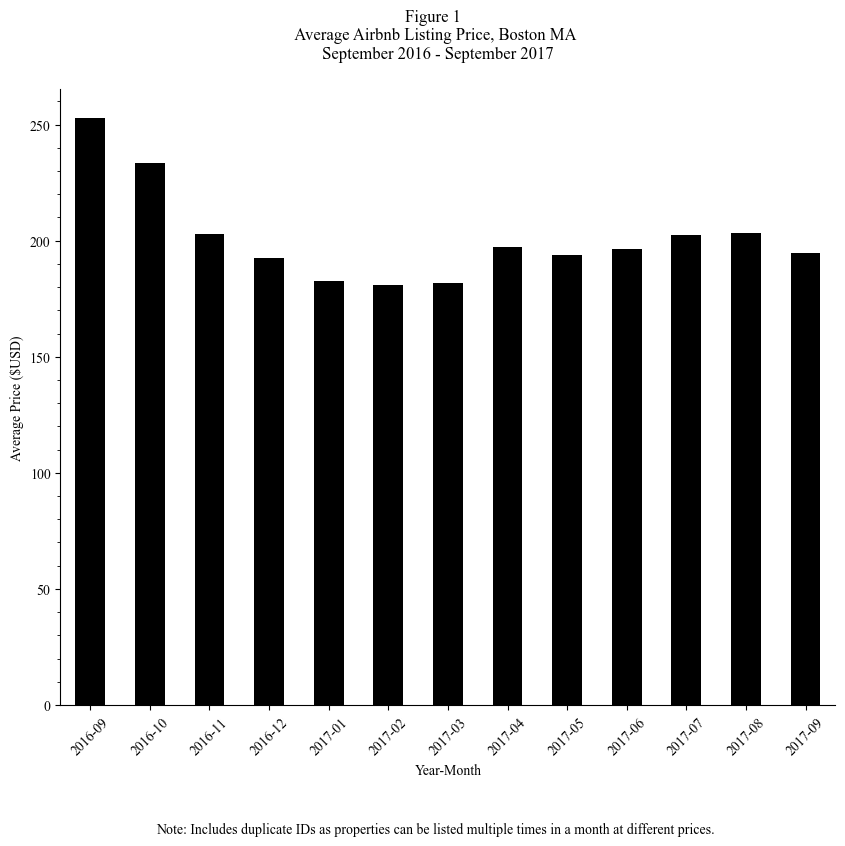

In [94]:
#Calculate the average listing price per month

#Calculate mean price per year-month
avg_list_price = CalLisCrime.groupby("year_month")["price"].mean().reset_index()

#Convert "year_month" column to string
avg_list_price["year_month"] = avg_list_price["year_month"].astype(str)

#Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
avg_list_price.plot(x="year_month", y="price", kind="bar", ax=ax, legend=False, color="black")

#Cleaning
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)
fig.suptitle("Figure 1 \n Average Airbnb Listing Price, Boston MA \n September 2016 - September 2017")
ax.set_xlabel("Year-Month")
plt.xticks(rotation=45)
ax.set_ylabel("Average Price ($USD)")
#Set y ticks to incriments of 10, where every 5th tick is major and labelled
ax.set_yticks(np.arange(0, 251, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)
plt.show()

Figure 1 shows the monthly average Airbnb listing price in Boston MA from September 2016 to September 2017.

I chose to visualize these variables because it is necessary to have a sense of the month to month variation in average listing price. This is because it is important to see if the average listing price even increased during the month that the Boston Marathon occured. If this is not the case, then I would have to re-work my research question and hypothesis.

These results are analgous to the results in Table 2. See section 3.1.

## 4.2. Density Histograms of Airbnb Listing Prices

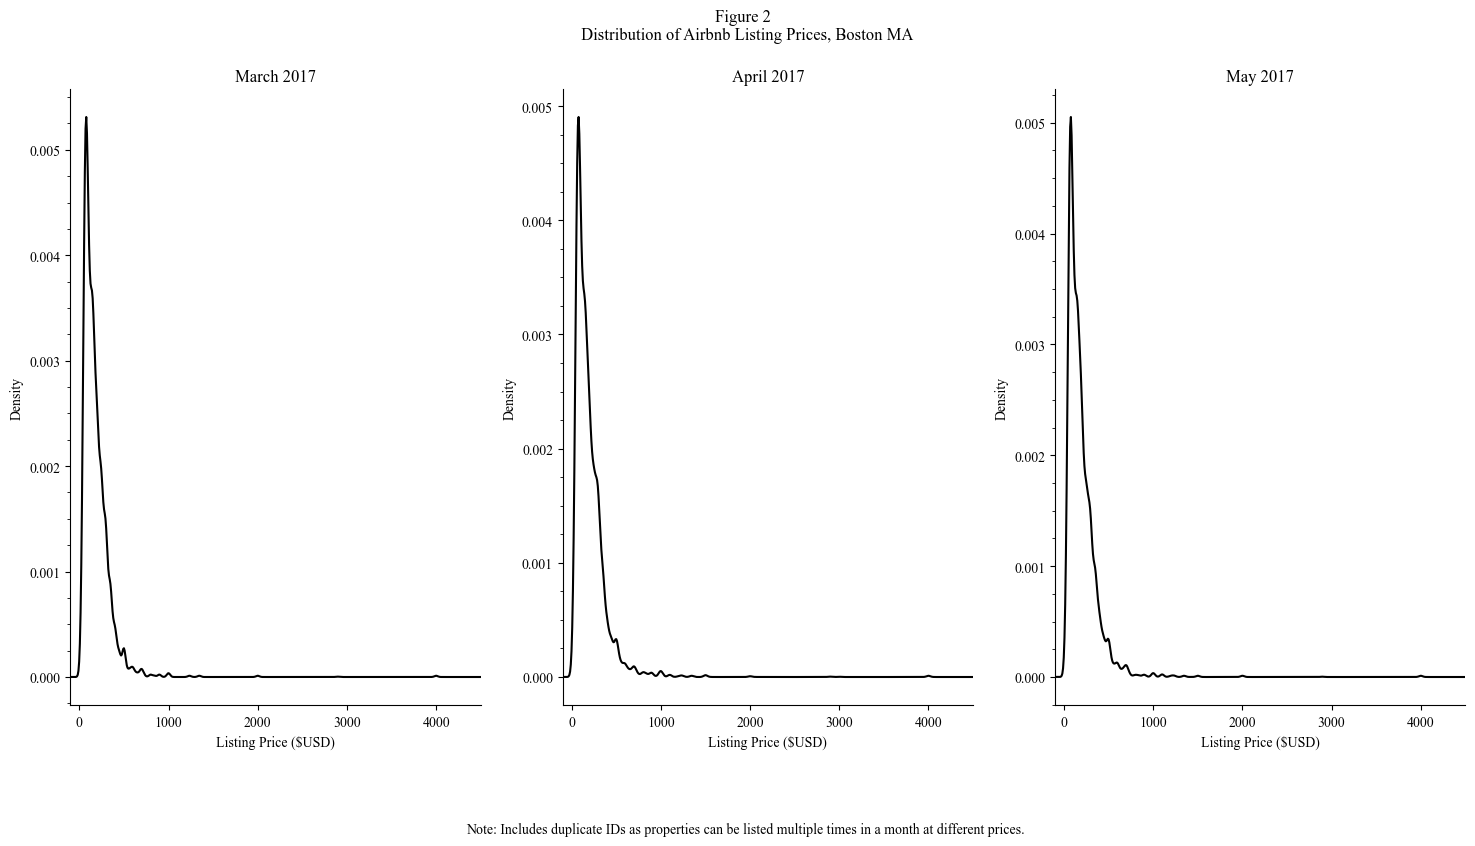

In [93]:
#Create temp datasets for each month
temp1 = CalLisCrime[CalLisCrime["year_month"] == "2017-03"]
temp2 = CalLisCrime[CalLisCrime["year_month"] == "2017-04"]
temp3 = CalLisCrime[CalLisCrime["year_month"] == "2017-05"]

#Create March histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

temp1.plot.density(y="price", ax=axes[0], legend=False, xlim=(-100, 4500), color="black") 

#Cleaning
axes[0].spines["right"].set_visible(False)   
axes[0].spines["top"].set_visible(False)

axes[0].set_title("March 2017")

axes[0].set_xlabel("Listing Price ($USD)")

axes[0].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[0].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April histogram
temp2.plot.density(y="price", ax=axes[1], legend=False, xlim=(-100, 4500), color = "black") 

#Cleaning
axes[1].spines["right"].set_visible(False)   
axes[1].spines["top"].set_visible(False)

axes[1].set_title("April 2017")

axes[1].set_xlabel("Listing Price ($USD)")

axes[1].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[1].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create May histogram
temp3.plot.density(y="price", ax=axes[2], legend=False, xlim=(-100, 4500), color="black") 

#Cleaning
axes[2].spines["right"].set_visible(False)   
axes[2].spines["top"].set_visible(False)

axes[2].set_title("May 2017")

axes[2].set_xlabel("Listing Price ($USD)")

axes[2].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[2].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

fig.suptitle("Figure 2 \n Distribution of Airbnb Listing Prices, Boston MA")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)
plt.show()

Figure 2 presents the distribution of Airbnb listing prices in Boston, MA for March, April, and May 2017.

I chose to analyze this distribution because price is my main outcome variable, and it is important to check for outliers and anomalies that can distory the mean listing price and bias my regression analysis. For instance, there is an outlier with a listing price around $4000. From this, I may consider dropping the outliers or doing a transformation, such as a log transformation, on the price variable.

Recall that the Boston Marathon occurs in April. Thus, I want to check if there is a significant change in the distribution of lising price due to increased demand brought about by the marathon. However, my figure shows that the distribution of prices is stable, despite potential fluctuations in prices. This result hints at the possibility of price changes due to the marathon being at a neighbourhood level, which supports my research design that groups neighbourhoods into treatment and control groups.   

## 4.3. Box Plots of Average Airbnb Listing Prices by Neighbourhood 

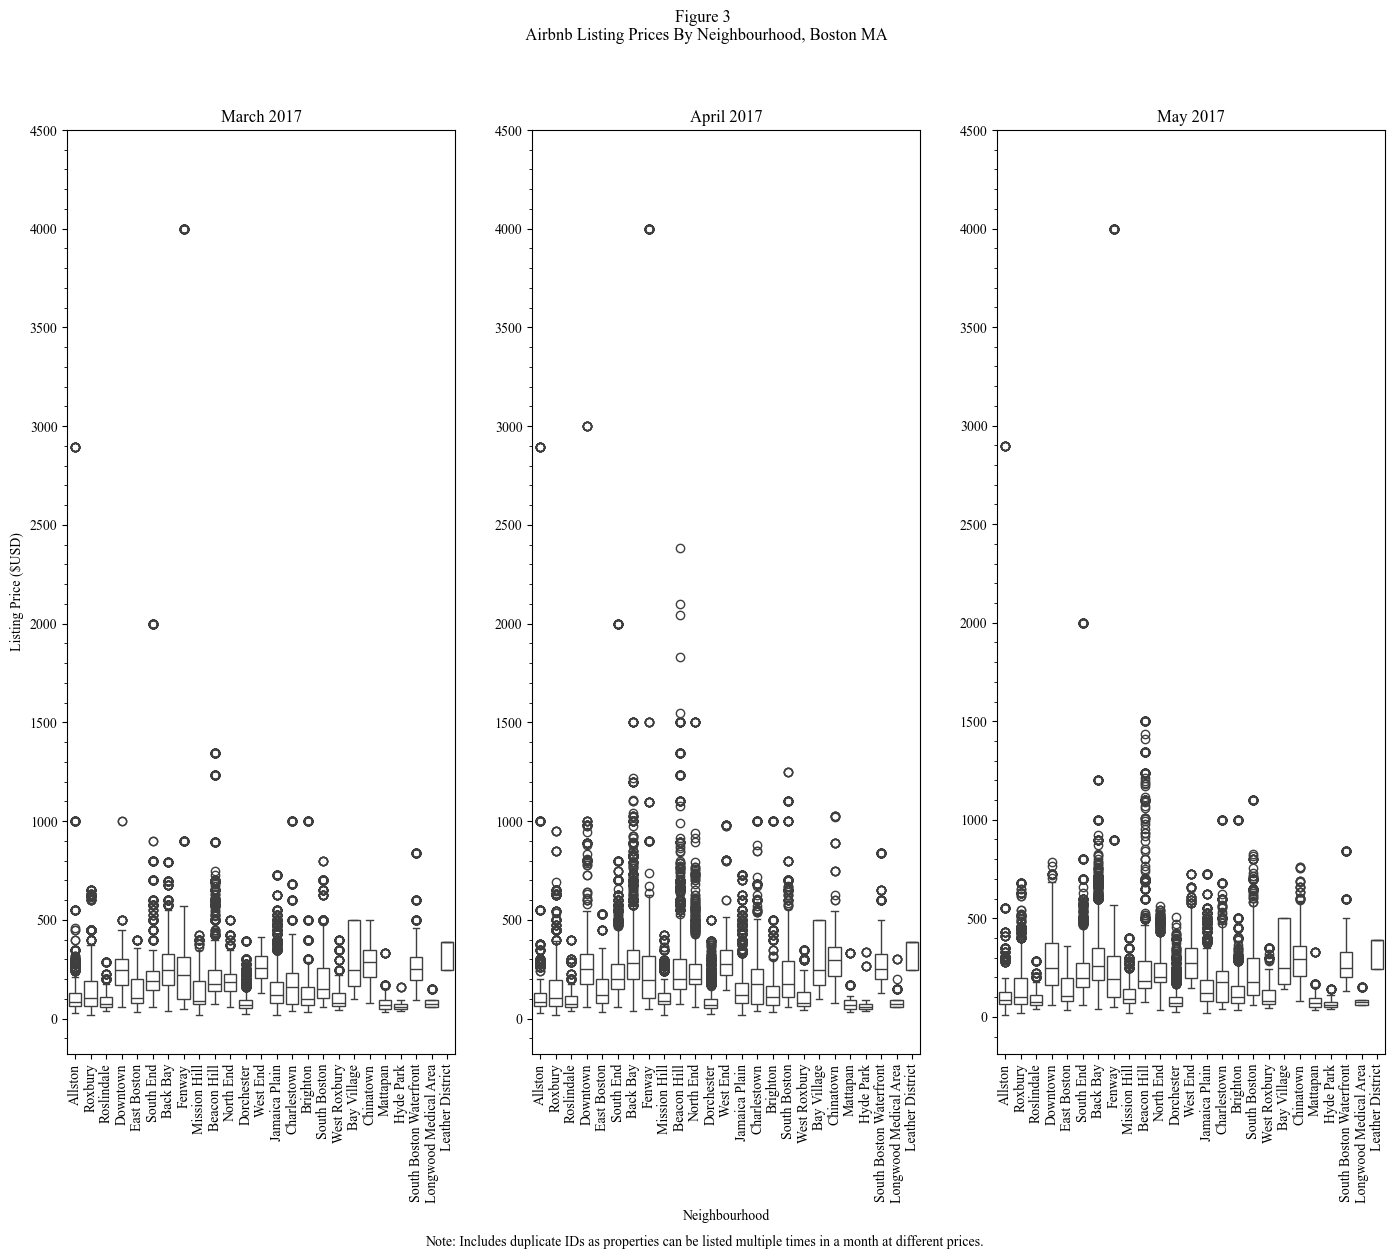

In [97]:
#Idea sourced from: https://www.kaggle.com/code/kostyabahshetsyan/boston-airbnb-visualization

#Create filtered datasets
dta_march17 = CalLisCrime[CalLisCrime["year_month"] == "2017-03"]
dta_april17 = CalLisCrime[CalLisCrime["year_month"] == "2017-04"]
dta_may17 = CalLisCrime[CalLisCrime["year_month"] == "2017-05"]

fig, axes = plt.subplots(1, 3, figsize = (17, 12))

#Create March 2017 boxplot
sns.boxplot(x ="neighbourhood_cleansed", y="price", data=dta_march17, ax=axes[0], boxprops=dict(facecolor="none"))

axes[0].set_title("March 2017")

axes[0].tick_params(axis="x", rotation=90)

axes[0].set_ylabel("Listing Price ($USD)")
axes[0].set_xlabel("")

axes[0].set_yticks(np.arange(0, 5000, 500)) 
axes[0].yaxis.set_minor_locator(mtick.MultipleLocator(100)) 

#Create April 2017 boxplot
sns.boxplot(x ="neighbourhood_cleansed", y="price", data=dta_april17, ax=axes[1], boxprops=dict(facecolor="none"))

axes[1].set_title("April 2017")

axes[1].tick_params(axis="x", rotation=90)

axes[1].set_ylabel("")
axes[1].set_xlabel("Neighbourhood")

axes[1].set_yticks(np.arange(0, 5000, 500)) 
axes[1].yaxis.set_minor_locator(mtick.MultipleLocator(100)) 

#Create May 2017 boxplot
sns.boxplot(x ="neighbourhood_cleansed", y="price", data=dta_may17, ax=axes[2], boxprops=dict(facecolor="none"))

axes[2].set_title("May 2017")

axes[2].tick_params(axis="x", rotation=90)

axes[2].set_ylabel("")
axes[2].set_xlabel("")

axes[2].set_yticks(np.arange(0, 5000, 500)) 
axes[2].yaxis.set_minor_locator(mtick.MultipleLocator(100)) 

fig.suptitle("Figure 3 \n Airbnb Listing Prices By Neighbourhood, Boston MA")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)

plt.show()


Figure 3 presents box plots of Airbnb listing prices for each neighbourhood in Boston, MA for the months March, April, and May 2017. 

This figure attempts to visualize if there is a significant change in the distribution of lising price at the neighbourhood level due to increased demand brought about by the Boston Marathon in April. Further, this visual helps me determine my treatment and control groups, the neighbourhoods impacted by the marathon and those which are not. Based on assessing a map of Boston neighbourhoods and the marathon route, the neighbourhoods closest to the marathon are Back Bay, Beacon Hill, Fenway, Allston, and Brighton, while those farthest and less likely to be affected are Jamaica Plain, West Roxbury, Mattapan, Roslindale, and Dorchester (). 

This figure shows that the listing prices in some of the closer/potential treatment neighbourhoods significantly change in April. For instance Back Bay has a higher mean and more outliers in April while Beacon Hill has a larger upper whisker and 75th percentile. However, Allston stays relatively consistent month to month. Yet, the farther/potential control neighbourhoods stay more consistent month to month than the treatment neighbourhoods. Therefore, these boxplots somewhat support my research questions and design, however more neighbourhood level data needs to be assessed to properly determine the treatment and control groups. For instance, I could check the rate of change of listing prices at the neighbourhood level month over month. Or, I can narrow the time frame to the days leading up to, the day of, and the days after the marathon.



## 4.4. Line Plot of Average Neighbourhood Price for Back Bay and West Roxbury Over Time

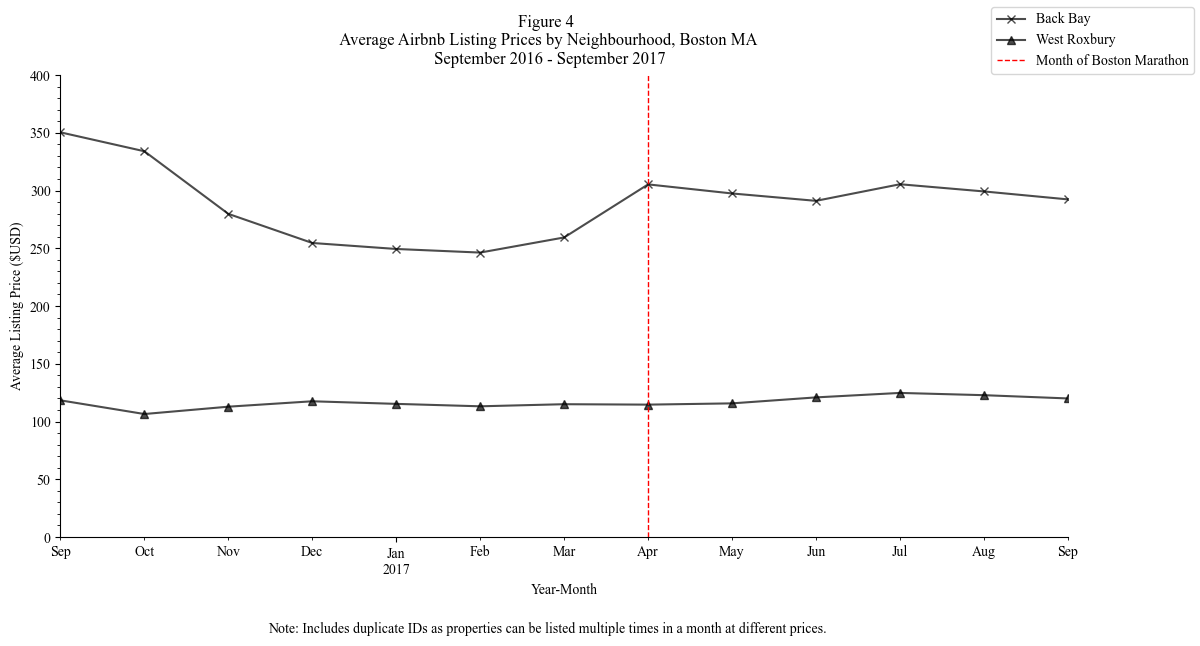

In [87]:
nei_price = CalLisCrime.groupby(["neighbourhood_cleansed", "year_month"])["price"].mean().reset_index()

nei_price_pivot = nei_price.pivot(index="year_month", columns="neighbourhood_cleansed",
                                  values="price")

nei_price_pivot.drop(columns=["Longwood Medical Area", "Leather District", "Chinatown",
                              "North End", "West End", "East Boston", "Hyde Park", "Bay Village",
                              "Mattapan", "South Boston Waterfront", "Allston", "Roslindale",
                              "Charlestown", "South Boston", "Brighton", "Mission Hill", "Beacon Hill",
                              "Dorchester", "Downtown", "Fenway", "Jamaica Plain", "Roxbury", "South End"], inplace=True)

#Create Plot
fig, ax = plt.subplots(figsize=(13, 6))

nei_price_pivot["Back Bay"].plot(ax=ax, alpha=0.7, legend=False, marker="x", color="black")

nei_price_pivot["West Roxbury"].plot(ax=ax, alpha=0.7, legend=False, marker="^", color="black")

#Boston Marathon Line
ax.axvline(x="2017-04", color="red", linestyle="--", linewidth=1, label="Month of Boston Marathon")

#Cleaning
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

ax.set_ylabel("Average Listing Price ($USD)")
ax.set_xlabel("Year-Month")
fig.suptitle("Figure 4 \n Average Airbnb Listing Prices by Neighbourhood, Boston MA \n September 2016 - September 2017")

ax.set_yticks(np.arange(0, 401, 50)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10)) 

fig.legend(loc="upper right")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)

plt.show()


Figure 4 presents the average Airbnb listing prices for Back Bay and West Roxbury from September 2016 to September 2017.

Both of these neighbourhoods are in Boston, MA. However, Back Bay is on the route of the April 2017 Boston Marathon, while West Roxbury is far away from said route. Thus, I assume that Back Bay serves as a treatment neighbourhood that is impacted by the marathon, while West Roxbury is a control that is not. 

This figure supports my hypothesis that the marathon had an impact on Airbnb prices, as Back Bay experiences a jump in average listing price in April while West Roxbury does not. If these 2 neighbourhoods were identical aside from the presence of the marathon, this would be the causal effect of the marathon on average listing prices. However, these neighbourhoods are not alike, we are not comparing 'apples to apples.' Thus, I cannot rule out that it was unobserved characteristics which led to the change in average listing price for Back Bay. This is why I need to include the beforementioned controls in my analysis. Regardless, however, this figure supports my research question, design, and hypothesis that the Boston Marathon does have an effect on Airbnb prices.

# 5. Conclusion

# Bibliography